## Basic training functionality

In [ ]:
from fastai.basic_train import *
from fastai.gen_doc.nbdoc import *
from fastai.vision import *
from fastai.distributed import *

[`basic_train`](/basic_train.html#basic_train) wraps together the data (in a [`DataBunch`](/basic_data.html#DataBunch) object) with a PyTorch model to define a [`Learner`](/basic_train.html#Learner) object. Here the basic training loop is defined for the [`fit`](/basic_train.html#fit) method. The [`Learner`](/basic_train.html#Learner) object is the entry point of most of the [`Callback`](/callback.html#Callback) objects that will customize this training loop in different ways. Some of the most commonly used customizations are available through the [`train`](/train.html#train) module, notably:

 - [`Learner.lr_find`](/train.html#lr_find) will launch an LR range test that will help you select a good learning rate.
 - [`Learner.fit_one_cycle`](/train.html#fit_one_cycle) will launch a training using the 1cycle policy to help you train your model faster.
 - [`Learner.to_fp16`](/train.html#to_fp16) will convert your model to half precision and help you launch a training in mixed precision.

In [ ]:
show_doc(Learner, title_level=2)

<h2 id="Learner"><code>class</code> <code>Learner</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L133" class="source_link">[source]</a></h2>

> <code>Learner</code>(**`data`**:[`DataBunch`](/basic_data.html#DataBunch), **`model`**:[`Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), **`opt_func`**:`Callable`=***`'Adam'`***, **`loss_func`**:`Callable`=***`None`***, **`metrics`**:`Collection`\[`Callable`\]=***`None`***, **`true_wd`**:`bool`=***`True`***, **`bn_wd`**:`bool`=***`True`***, **`wd`**:`Floats`=***`0.01`***, **`train_bn`**:`bool`=***`True`***, **`path`**:`str`=***`None`***, **`model_dir`**:`str`=***`'models'`***, **`callback_fns`**:`Collection`\[`Callable`\]=***`None`***, **`callbacks`**:`Collection`\[[`Callback`](/callback.html#Callback)\]=***`<factory>`***, **`layer_groups`**:`ModuleList`=***`None`***)

Trainer for `model` using `data` to minimize `loss_func` with optimizer `opt_func`.  

The main purpose of [`Learner`](/basic_train.html#Learner) is to train `model` using [`Learner.fit`](/basic_train.html#Learner.fit). After every epoch, all *metrics* will be printed and also made available to callbacks.

The default weight decay will be `wd`, which will be handled using the method from [Fixing Weight Decay Regularization in Adam](https://arxiv.org/abs/1711.05101) if `true_wd` is set (otherwise it's L2 regularization). If `bn_wd` is `False`, then weight decay will be removed from batchnorm layers, as recommended in [Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour](https://arxiv.org/abs/1706.02677). If `train_bn`, batchnorm layer learnable params are trained even for frozen layer groups.

To use [discriminative layer training](#Discriminative-layer-training), pass a list of [`nn.Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) as `layer_groups`; each [`nn.Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) will be used to customize the optimization of the corresponding layer group.

If `path` is provided, all the model files created will be saved in `path`/`model_dir`; if not, then they will be saved in `data.path`/`model_dir`.

You can pass a list of [`callback`](/callback.html#callback)s that you have already created, or (more commonly) simply pass a list of callback functions to `callback_fns` and each function will be called (passing `self`) on object initialization, with the results stored as callback objects. For a walk-through, see the [training overview](/training.html) page. You may also want to use an [application](applications.html) specific model. For example, if you are dealing with a vision dataset, here the MNIST, you might want to use the [`create_cnn`](/vision.learner.html#create_cnn) method:

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
learn = create_cnn(data, models.resnet18, metrics=accuracy)

### Model fitting methods

In [ ]:
show_doc(Learner.fit)

<h4 id="Learner.fit"><code>fit</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L169" class="source_link">[source]</a></h4>

> <code>fit</code>(**`epochs`**:`int`, **`lr`**:`Union`\[`float`, `Collection`\[`float`\], `slice`\]=***`slice(None, 0.003, None)`***, **`wd`**:`Floats`=***`None`***, **`callbacks`**:`Collection`\[[`Callback`](/callback.html#Callback)\]=***`None`***)

Fit the model on this learner with `lr` learning rate, `wd` weight decay for `epochs` with `callbacks`.  

Uses [discriminative layer training](#Discriminative-layer-training) if multiple learning rates or weight decay values are passed. To control training behaviour, use the [`callback`](/callback.html#callback) system or one or more of the pre-defined [`callbacks`](/callbacks.html#callbacks).

In [ ]:
learn.fit(1)

epoch,train_loss,valid_loss,accuracy
1,0.135587,0.082969,0.973503


In [ ]:
show_doc(Learner.fit_one_cycle)

<h4 id="fit_one_cycle"><code>fit_one_cycle</code><a href="https://github.com/fastai/fastai/blob/master/fastai/train.py#L14" class="source_link">[source]</a></h4>

> <code>fit_one_cycle</code>(**`learn`**:[`Learner`](/basic_train.html#Learner), **`cyc_len`**:`int`, **`max_lr`**:`Union`\[`float`, `Collection`\[`float`\], `slice`\]=***`slice(None, 0.003, None)`***, **`moms`**:`Point`=***`(0.95, 0.85)`***, **`div_factor`**:`float`=***`25.0`***, **`pct_start`**:`float`=***`0.3`***, **`wd`**:`float`=***`None`***, **`callbacks`**:`Optional`\[`Collection`\[[`Callback`](/callback.html#Callback)\]\]=***`None`***, **`tot_epochs`**:`int`=***`None`***, **`start_epoch`**:`int`=***`1`***)

Fit a model following the 1cycle policy.  

Use cycle length `cyc_len`, a per cycle maximal learning rate `max_lr`, momentum `moms`, division factor `div_factor`, weight decay `wd`, and optional callbacks [`callbacks`](/callbacks.html#callbacks). Uses the [`OneCycleScheduler`](/callbacks.one_cycle.html#OneCycleScheduler) callback. Please refer to [What is 1-cycle](/callbacks.one_cycle.html#What-is-1cycle?) for a conceptual background of 1-cycle training policy and more technical details on what do the method's arguments do.

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,0.080337,0.062688,0.978901


In [ ]:
show_doc(Learner.lr_find)

<h4 id="lr_find"><code>lr_find</code><a href="https://github.com/fastai/fastai/blob/master/fastai/train.py#L24" class="source_link">[source]</a></h4>

> <code>lr_find</code>(**`learn`**:[`Learner`](/basic_train.html#Learner), **`start_lr`**:`Floats`=***`1e-07`***, **`end_lr`**:`Floats`=***`10`***, **`num_it`**:`int`=***`100`***, **`stop_div`**:`bool`=***`True`***, **`wd`**:`float`=***`None`***)

Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.  

Runs the learning rate finder defined in [`LRFinder`](/callbacks.lr_finder.html#LRFinder), as discussed in [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186). 

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


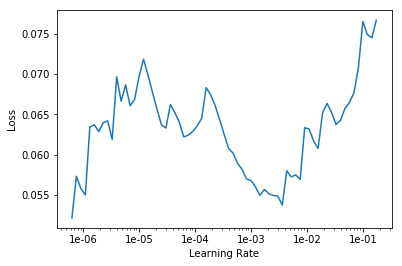

In [ ]:
learn.recorder.plot()

### See results

In [ ]:
show_doc(Learner.get_preds)

<h4 id="Learner.get_preds"><code>get_preds</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L273" class="source_link">[source]</a></h4>

> <code>get_preds</code>(**`ds_type`**:[`DatasetType`](/basic_data.html#DatasetType)=***`<DatasetType.Valid: 2>`***, **`with_loss`**:`bool`=***`False`***, **`n_batch`**:`Optional`\[`int`\]=***`None`***, **`pbar`**:`Union`\[`MasterBar`, `ProgressBar`, `NoneType`\]=***`None`***) → `List`\[`Tensor`\]

Return predictions and targets on `ds_type` dataset.  

It will run inference using the learner on all the data in the `ds_type` dataset and return the predictions; if `n_batch` is not specified, it will run the predictions on the default batch size. If `with_loss`, it will also return the loss on each prediction.

Here is how you check the default batch size.

In [ ]:
learn.data.batch_size

64

In [ ]:
preds = learn.get_preds()
preds

[tensor([[9.9540e-01, 4.5968e-03],
         [9.9925e-01, 7.5202e-04],
         [9.9996e-01, 4.2987e-05],
         ...,
         [1.4036e-04, 9.9986e-01],
         [1.0404e-01, 8.9596e-01],
         [5.6783e-01, 4.3217e-01]]), tensor([0, 0, 0,  ..., 1, 1, 1])]

The first element of the tuple is a tensor that contains all the predictions.

In [ ]:
preds[0]

tensor([[9.9540e-01, 4.5968e-03],
        [9.9925e-01, 7.5202e-04],
        [9.9996e-01, 4.2987e-05],
        ...,
        [1.4036e-04, 9.9986e-01],
        [1.0404e-01, 8.9596e-01],
        [5.6783e-01, 4.3217e-01]])

While the second element of the tuple is a tensor that contains all the targets.

In [ ]:
preds[1]

tensor([0, 0, 0,  ..., 1, 1, 1])

In [ ]:
preds[1][0]

tensor(0)

To see what each category is, use:

In [ ]:
learn.data.classes

['3', '7']

So category 0 is 3 while category 1 is 7.

In [ ]:
learn.data.valid_ds[0]

(Image (3, 28, 28), Category 3)

In [ ]:
learn.data.valid_ds[0][0]

Indeed it is.

Since [`get_preds`](/basic_train.html#get_preds) gets predictions on all the data in the `ds_type` dataset, here the number of predictions will be equal to the number of data in the validation dataset.

In [ ]:
len(learn.data.valid_ds)

2038

In [ ]:
len(preds[0]), len(preds[1])

(2038, 2038)

Since the dataset we are working on is a categorization dataset, every prediction contains two numbers; the first one indicates the probability that the item belongs to the first category, and the second one indicates the probability that it belongs to the second.

In [ ]:
preds[0]

tensor([[9.9540e-01, 4.5968e-03],
        [9.9925e-01, 7.5202e-04],
        [9.9996e-01, 4.2987e-05],
        ...,
        [1.4036e-04, 9.9986e-01],
        [1.0404e-01, 8.9596e-01],
        [5.6783e-01, 4.3217e-01]])

In [ ]:
preds[0][0]

tensor([0.9954, 0.0046])

Here, the first number is the predicted probability that the item is a 3, while the second number 7.

In [ ]:
learn.data.valid_ds[0][0]

To get predictions on the entire training dataset, simply set the `ds_type` argument accordingly.

In [ ]:
learn.get_preds(ds_type=DatasetType.Train)

[tensor([[1.6543e-02, 9.8346e-01],
         [9.9998e-01, 1.5066e-05],
         [5.2995e-04, 9.9947e-01],
         ...,
         [9.9844e-01, 1.5631e-03],
         [3.9617e-05, 9.9996e-01],
         [4.1428e-05, 9.9996e-01]]), tensor([1, 0, 1,  ..., 0, 1, 1])]

To also get prediction loss along with the predictions and the targets, set `with_loss=True` in the arguments.

In [ ]:
learn.get_preds(with_loss=True)

[tensor([[9.9540e-01, 4.5968e-03],
         [9.9925e-01, 7.5202e-04],
         [9.9996e-01, 4.2987e-05],
         ...,
         [1.4036e-04, 9.9986e-01],
         [1.0404e-01, 8.9596e-01],
         [5.6783e-01, 4.3217e-01]]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([4.6074e-03, 7.5221e-04, 4.2915e-05,  ..., 1.4043e-04, 1.0986e-01,
         8.3894e-01])]

Note that the third tensor in the output tuple contains the losses.

In [ ]:
show_doc(Learner.validate)

<h4 id="Learner.validate"><code>validate</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L317" class="source_link">[source]</a></h4>

> <code>validate</code>(**`dl`**=***`None`***, **`callbacks`**=***`None`***, **`metrics`**=***`None`***)

Validate on `dl` with potential `callbacks` and `metrics`.  

Return the calculated loss and the metrics of the current model on the given data loader `dl`. The default data loader `dl` is the validation dataloader.

You can check the default metrics of the learner using:

In [ ]:
str(learn.metrics)

'[<function accuracy at 0x7f061d2839d8>]'

In [ ]:
learn.validate()

[0.062688194, tensor(0.9789)]

In [ ]:
learn.validate(learn.data.valid_dl)

[0.062688194, tensor(0.9789)]

In [ ]:
learn.validate(learn.data.train_dl)

[0.044597004, tensor(0.9832)]

In [ ]:
show_doc(Learner.show_results)

<h4 id="Learner.show_results"><code>show_results</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L327" class="source_link">[source]</a></h4>

> <code>show_results</code>(**`ds_type`**=***`<DatasetType.Valid: 2>`***, **`rows`**:`int`=***`5`***, **\*\*`kwargs`**)

Show `rows` result of predictions on `ds_type` dataset.  

In [ ]:
show_doc(Learner.predict)

<h4 id="Learner.predict"><code>predict</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L303" class="source_link">[source]</a></h4>

> <code>predict</code>(**`item`**:[`ItemBase`](/core.html#ItemBase), **\*\*`kwargs`**)

Return predicted class, label and probabilities for `item`.  

In [ ]:
show_doc(Learner.pred_batch)

<h4 id="Learner.pred_batch"><code>pred_batch</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L280" class="source_link">[source]</a></h4>

> <code>pred_batch</code>(**`ds_type`**:[`DatasetType`](/basic_data.html#DatasetType)=***`<DatasetType.Valid: 2>`***, **`batch`**:`Tuple`=***`None`***, **`reconstruct`**:`bool`=***`False`***) → `List`\[`Tensor`\]

Return output of the model on one batch from `ds_type` dataset.  

In [ ]:
show_doc(Learner.interpret, full_name='interpret')

<h4 id="interpret"><code>interpret</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L164" class="source_link">[source]</a></h4>

> <code>interpret</code>(**`learn`**:[`Learner`](/basic_train.html#Learner), **`ds_type`**:[`DatasetType`](/basic_data.html#DatasetType)=***`<DatasetType.Valid: 2>`***, **`tta`**=***`False`***)

Create a [`ClassificationInterpretation`](/train.html#ClassificationInterpretation) object from `learner` on `ds_type` with `tta`.  

In [ ]:
jekyll_note('This function only works in the vision application.')

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>This function only works in the vision application.</div>

### Model summary

In [ ]:
show_doc(Learner.summary)

<h4 id="model_summary"><code>model_summary</code><a href="https://github.com/fastai/fastai/blob/master/fastai/callbacks/hooks.py#L165" class="source_link">[source]</a></h4>

> <code>model_summary</code>(**`m`**:[`Learner`](/basic_train.html#Learner), **`n`**:`int`=***`70`***)

Print a summary of `m` using a output text width of `n` chars  

### Test time augmentation

In [ ]:
show_doc(Learner.TTA, full_name = 'TTA')

<h4 id="TTA"><code>TTA</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/tta.py#L32" class="source_link">[source]</a></h4>

> <code>TTA</code>(**`learn`**:[`Learner`](/basic_train.html#Learner), **`beta`**:`float`=***`0.4`***, **`scale`**:`float`=***`1.35`***, **`ds_type`**:[`DatasetType`](/basic_data.html#DatasetType)=***`<DatasetType.Valid: 2>`***, **`with_loss`**:`bool`=***`False`***) → `Tensors`

Applies TTA to predict on `ds_type` dataset.  

Applies Test Time Augmentation to `learn` on the dataset `ds_type`. We take the average of our regular predictions (with a weight `beta`) with the average of predictions obtained through augmented versions of the training set (with a weight `1-beta`). The transforms decided for the training set are applied with a few changes `scale` controls the scale for zoom (which isn't random), the cropping isn't random but we make sure to get the four corners of the image. Flipping isn't random but applied once on each of those corner images (so that makes 8 augmented versions total).

### Gradient clipping

In [ ]:
show_doc(Learner.clip_grad)

<h4 id="clip_grad"><code>clip_grad</code><a href="https://github.com/fastai/fastai/blob/master/fastai/train.py#L96" class="source_link">[source]</a></h4>

> <code>clip_grad</code>(**`learn`**:[`Learner`](/basic_train.html#Learner), **`clip`**:`float`=***`0.1`***) → [`Learner`](/basic_train.html#Learner)

Add gradient clipping of `clip` during training.  

### Mixed precision training

In [ ]:
show_doc(Learner.to_fp16)

<h4 id="to_fp16"><code>to_fp16</code><a href="https://github.com/fastai/fastai/blob/master/fastai/train.py#L34" class="source_link">[source]</a></h4>

> <code>to_fp16</code>(**`learn`**:[`Learner`](/basic_train.html#Learner), **`loss_scale`**:`float`=***`None`***, **`max_noskip`**:`int`=***`1000`***, **`dynamic`**:`bool`=***`False`***, **`clip`**:`float`=***`None`***, **`flat_master`**:`bool`=***`False`***) → [`Learner`](/basic_train.html#Learner)

Put `learn` in FP16 precision mode.  

Uses the [`MixedPrecision`](/callbacks.fp16.html#MixedPrecision) callback to train in mixed precision (i.e. forward and backward passes using fp16, with weight updates using fp32), using all [NVIDIA recommendations](https://docs.nvidia.com/deeplearning/sdk/mixed-precision-training/index.html) for ensuring speed and accuracy.

In [ ]:
show_doc(Learner.to_fp32)

<h4 id="to_fp32"><code>to_fp32</code><a href="https://github.com/fastai/fastai/blob/master/fastai/train.py#L43" class="source_link">[source]</a></h4>

> <code>to_fp32</code>(**`learn`**:[`Learner`](/basic_train.html#Learner))

Put `learn` back to FP32 precision mode.  

### Distributed training

In [ ]:
show_doc(Learner.distributed, full_name='distributed')

<h4 id="distributed"><code>distributed</code><a href="https://github.com/fastai/fastai/blob/master/fastai/distributed.py#L59" class="source_link">[source]</a></h4>

> <code>distributed</code>(**`learn`**:[`Learner`](/basic_train.html#Learner), **`cuda_id`**:`int`, **`cache_dir`**:`PathOrStr`=***`'tmp'`***)

Put `learn` on distributed training with `cuda_id`.  

### Discriminative layer training

When fitting a model you can pass a list of learning rates (and/or weight decay amounts), which will apply a different rate to each *layer group* (i.e. the parameters of each module in `self.layer_groups`). See the [Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/abs/1801.06146) paper for details and experimental results in NLP (we also frequently use them successfully in computer vision, but have not published a paper on this topic yet). When working with a [`Learner`](/basic_train.html#Learner) on which you've called `split`, you can set hyperparameters in four ways:

1. `param = [val1, val2 ..., valn]` (n = number of layer groups)
2. `param = val`
3. `param = slice(start,end)`
4. `param = slice(end)`

If we chose to set it in way 1, we must specify a number of values exactly equal to the number of layer groups. If we chose to set it in way 2, the chosen value will be repeated for all layer groups. See [`Learner.lr_range`](/basic_train.html#Learner.lr_range) for an explanation of the `slice` syntax).

Here's an example of how to use discriminative learning rates (note that you don't actually need to manually call [`Learner.split`](/basic_train.html#Learner.split) in this case, since fastai uses this exact function as the default split for `resnet18`; this is just to show how to customize it):

In [ ]:
# creates 3 layer groups
learn.split(lambda m: (m[0][6], m[1]))
# only randomly initialized head now trainable
learn.freeze()

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,0.069001,0.045998,0.983317


In [ ]:
# all layers now trainable
learn.unfreeze()
# optionally, separate LR and WD for each group
learn.fit_one_cycle(1, max_lr=(1e-4, 1e-3, 1e-2), wd=(1e-4,1e-4,1e-1))

epoch,train_loss,valid_loss,accuracy
1,0.021191,0.008666,0.997056


In [ ]:
show_doc(Learner.lr_range)

<h4 id="Learner.lr_range"><code>lr_range</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L162" class="source_link">[source]</a></h4>

> <code>lr_range</code>(**`lr`**:`Union`\[`float`, `slice`\]) → `ndarray`

Build differential learning rates from `lr`.  

Rather than manually setting an LR for every group, it's often easier to use [`Learner.lr_range`](/basic_train.html#Learner.lr_range). This is a convenience method that returns one learning rate for each layer group. If you pass `slice(start,end)` then the first group's learning rate is `start`, the last is `end`, and the remaining are evenly geometrically spaced.

If you pass just `slice(end)` then the last group's learning rate is `end`, and all the other groups are `end/10`. For instance (for our learner that has 3 layer groups):

In [ ]:
learn.lr_range(slice(1e-5,1e-3)), learn.lr_range(slice(1e-3))

(array([1.e-05, 1.e-04, 1.e-03]), array([0.0001, 0.0001, 0.001 ]))

In [ ]:
show_doc(Learner.unfreeze)

<h4 id="Learner.unfreeze"><code>unfreeze</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L203" class="source_link">[source]</a></h4>

> <code>unfreeze</code>()

Unfreeze entire model.  

Sets every layer group to *trainable* (i.e. `requires_grad=True`).

In [ ]:
show_doc(Learner.freeze)

<h4 id="Learner.freeze"><code>freeze</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L197" class="source_link">[source]</a></h4>

> <code>freeze</code>()

Freeze up to last layer.  

Sets every layer group except the last to *untrainable* (i.e. `requires_grad=False`).

In [ ]:
show_doc(Learner.freeze_to)

<h4 id="Learner.freeze_to"><code>freeze_to</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L189" class="source_link">[source]</a></h4>

> <code>freeze_to</code>(**`n`**:`int`)

Freeze layers up to layer `n`.  

In [ ]:
show_doc(Learner.split)

<h4 id="Learner.split"><code>split</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L184" class="source_link">[source]</a></h4>

> <code>split</code>(**`split_on`**:`SplitFuncOrIdxList`)

Split the model at `split_on`.  

A convenience method that sets `layer_groups` based on the result of [`split_model`](/torch_core.html#split_model). If `split_on` is a function, it calls that function and passes the result to [`split_model`](/torch_core.html#split_model) (see above for example).

### Saving and loading models

Simply call [`Learner.save`](/basic_train.html#Learner.save) and [`Learner.load`](/basic_train.html#Learner.load) to save and load models. Only the parameters are saved, not the actual architecture (so you'll need to create your model in the same way before loading weights back in). Models are saved to the `path`/`model_dir` directory.

In [ ]:
show_doc(Learner.load)

<h4 id="Learner.load"><code>load</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L235" class="source_link">[source]</a></h4>

> <code>load</code>(**`name`**:`PathOrStr`, **`device`**:[`device`](https://pytorch.org/docs/stable/tensor_attributes.html#torch-device)=***`None`***, **`strict`**:`bool`=***`True`***, **`with_opt`**:`bool`=***`None`***, **`purge`**:`bool`=***`True`***)

Load model and optimizer state (if `with_opt`) `name` from `self.model_dir` using `device`.  

In [ ]:
show_doc(Learner.save)

<h4 id="Learner.save"><code>save</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L223" class="source_link">[source]</a></h4>

> <code>save</code>(**`name`**:`PathOrStr`, **`return_path`**:`bool`=***`False`***, **`with_opt`**:`bool`=***`True`***)

Save model and optimizer state (if `with_opt`) with `name` to `self.model_dir`.  

### Deploying your model

When you are ready to put your model in production, export the minimal state of your [`Learner`](/basic_train.html#Learner) with

In [ ]:
show_doc(Learner.export)

<h4 id="Learner.export"><code>export</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L208" class="source_link">[source]</a></h4>

> <code>export</code>(**`fname`**:`str`=***`'export.pkl'`***)

Export the state of the [`Learner`](/basic_train.html#Learner) in `self.path/fname`.  

Then you can load it with the following function.

In [ ]:
show_doc(load_learner)

<h4 id="load_learner"><code>load_learner</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L499" class="source_link">[source]</a></h4>

> <code>load_learner</code>(**`path`**:`PathOrStr`, **`fname`**:`PathOrStr`=***`'export.pkl'`***, **`test`**:[`ItemList`](/data_block.html#ItemList)=***`None`***)

Load a [`Learner`](/basic_train.html#Learner) object saved with `export_state` in `path/fn` with empty data, optionally add `test` and load on `cpu`.  

You can find more information and multiple examples in [this tutorial](/tutorial.inference.html)

### Other methods

In [ ]:
show_doc(Learner.init)

<h4 id="Learner.init"><code>init</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L160" class="source_link">[source]</a></h4>

> <code>init</code>(**`init`**)

Initializes all weights (except batchnorm) using function `init`, which will often be from PyTorch's [`nn.init`](https://pytorch.org/docs/stable/nn.html#torch-nn-init) module.

In [ ]:
show_doc(Learner.mixup)

<h4 id="mixup"><code>mixup</code><a href="https://github.com/fastai/fastai/blob/master/fastai/train.py#L55" class="source_link">[source]</a></h4>

> <code>mixup</code>(**`learn`**:[`Learner`](/basic_train.html#Learner), **`alpha`**:`float`=***`0.4`***, **`stack_x`**:`bool`=***`False`***, **`stack_y`**:`bool`=***`True`***) → [`Learner`](/basic_train.html#Learner)

Add mixup https://arxiv.org/abs/1710.09412 to `learn`.  

Uses [`MixUpCallback`](/callbacks.mixup.html#MixUpCallback).

In [ ]:
show_doc(Learner.backward)

<h4 id="Learner.backward"><code>backward</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L296" class="source_link">[source]</a></h4>

> <code>backward</code>(**`item`**)

Pass `item` through the model and computes the gradient. Useful if `backward_hooks` are attached.  

In [ ]:
show_doc(Learner.create_opt)

<h4 id="Learner.create_opt"><code>create_opt</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L180" class="source_link">[source]</a></h4>

> <code>create_opt</code>(**`lr`**:`Floats`, **`wd`**:`Floats`=***`0.0`***)

Create optimizer with `lr` learning rate and `wd` weight decay.  

You generally won't need to call this yourself - it's used to create the [`optim`](https://pytorch.org/docs/stable/optim.html#module-torch.optim) optimizer before fitting the model.

In [ ]:
show_doc(Learner.dl)

<h4 id="Learner.dl"><code>dl</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L231" class="source_link">[source]</a></h4>

> <code>dl</code>(**`ds_type`**:[`DatasetType`](/basic_data.html#DatasetType)=***`<DatasetType.Valid: 2>`***)

Return DataLoader for DatasetType `ds_type`.  

In [ ]:
show_doc(Recorder, title_level=2)

<h2 id="Recorder"><code>class</code> <code>Recorder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L378" class="source_link">[source]</a></h2>

> <code>Recorder</code>(**`learn`**:[`Learner`](/basic_train.html#Learner)) :: [`LearnerCallback`](/basic_train.html#LearnerCallback)

A [`LearnerCallback`](/basic_train.html#LearnerCallback) that records epoch, loss, opt and metric data during training.  

A [`Learner`](/basic_train.html#Learner) creates a [`Recorder`](/basic_train.html#Recorder) object automatically - you do not need to explicitly pass it to `callback_fns` - because other callbacks rely on it being available. It stores the smoothed loss, hyperparameter values, and metrics for each batch, and provides plotting methods for each. Note that [`Learner`](/basic_train.html#Learner) automatically sets an attribute with the snake-cased name of each callback, so you can access this through `Learner.recorder`, as shown below.

### Plotting methods

In [ ]:
show_doc(Recorder.plot)

<h4 id="Recorder.plot"><code>plot</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L448" class="source_link">[source]</a></h4>

> <code>plot</code>(**`skip_start`**:`int`=***`10`***, **`skip_end`**:`int`=***`5`***)

Plot learning rate and losses, trimmed between `skip_start` and `skip_end`. Optionally plot and return min gradient  

This is mainly used with the learning rate finder, since it shows a scatterplot of loss vs learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


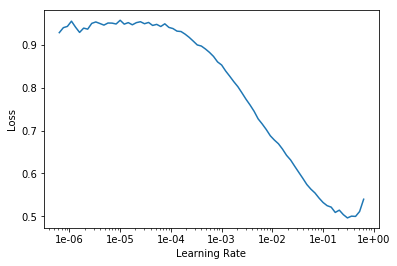

In [ ]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.lr_find()
learn.recorder.plot()

In [ ]:
show_doc(Recorder.plot_losses)

<h4 id="Recorder.plot_losses"><code>plot_losses</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L463" class="source_link">[source]</a></h4>

> <code>plot_losses</code>(**`last`**:`int`=***`None`***)

Plot training and validation losses.  

Note that validation losses are only calculated once per epoch, whereas training losses are calculated after every batch.

epoch,train_loss,valid_loss,accuracy
1,0.193293,0.107442,0.968106
2,0.093543,0.076363,0.977429


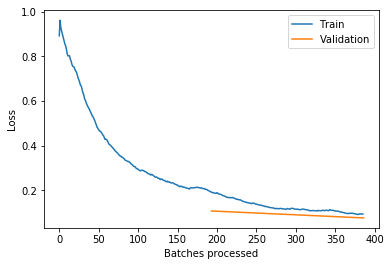

In [ ]:
learn.fit_one_cycle(2)
learn.recorder.plot_losses()

In [ ]:
show_doc(Recorder.plot_lr)

<h4 id="Recorder.plot_lr"><code>plot_lr</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L435" class="source_link">[source]</a></h4>

> <code>plot_lr</code>(**`show_moms`**=***`False`***)

Plot learning rate, `show_moms` to include momentum.  

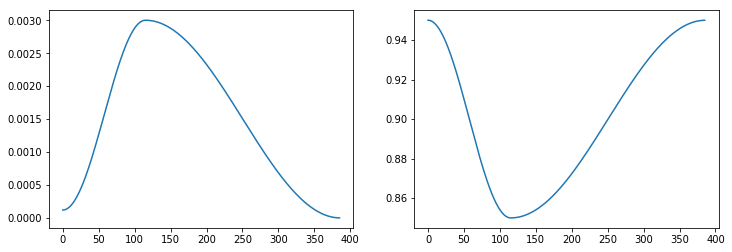

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
show_doc(Recorder.plot_metrics)

<h4 id="Recorder.plot_metrics"><code>plot_metrics</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L478" class="source_link">[source]</a></h4>

> <code>plot_metrics</code>()

Plot metrics collected during training.  

Note that metrics are only collected at the end of each epoch, so you'll need to train at least two epochs to have anything to show here.

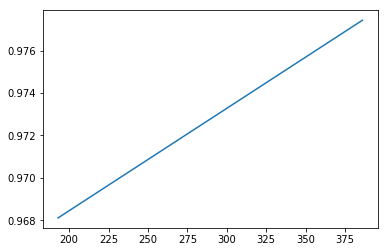

In [ ]:
learn.recorder.plot_metrics()

### Callback methods

You don't call these yourself - they're called by fastai's [`Callback`](/callback.html#Callback) system automatically to enable the class's functionality.

In [ ]:
show_doc(Recorder.on_backward_begin)

<h4 id="Recorder.on_backward_begin"><code>on_backward_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L402" class="source_link">[source]</a></h4>

> <code>on_backward_begin</code>(**`smooth_loss`**:`Tensor`, **\*\*`kwargs`**:`Any`)

Record the loss before any other callback has a chance to modify it.  

In [ ]:
show_doc(Recorder.on_batch_begin)

<h4 id="Recorder.on_batch_begin"><code>on_batch_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L396" class="source_link">[source]</a></h4>

> <code>on_batch_begin</code>(**`train`**, **\*\*`kwargs`**:`Any`)

Record learning rate and momentum at beginning of batch.  

In [ ]:
show_doc(Recorder.on_epoch_end)

<h4 id="Recorder.on_epoch_end"><code>on_epoch_end</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L408" class="source_link">[source]</a></h4>

> <code>on_epoch_end</code>(**`epoch`**:`int`, **`num_batch`**:`int`, **`smooth_loss`**:`Tensor`, **`last_metrics`**=***`typing.Collection[typing.Union[torch.Tensor, numbers.Number]]`***, **\*\*`kwargs`**:`Any`) → `bool`

Save epoch info: num_batch, smooth_loss, metrics.  

In [ ]:
show_doc(Recorder.on_train_begin)

<h4 id="Recorder.on_train_begin"><code>on_train_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L387" class="source_link">[source]</a></h4>

> <code>on_train_begin</code>(**`pbar`**:`PBar`, **`metrics_names`**:`StrList`, **\*\*`kwargs`**:`Any`)

Initialize recording status at beginning of training.  

### Inner functions

The following functions are used along the way by the [`Recorder`](/basic_train.html#Recorder) or can be called by other callbacks.

In [ ]:
show_doc(Recorder.add_metrics)

<h4 id="Recorder.add_metrics"><code>add_metrics</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L427" class="source_link">[source]</a></h4>

> <code>add_metrics</code>(**`metrics`**)

Add `metrics` to the inner stats.  

In [ ]:
show_doc(Recorder.add_metric_names)

<h4 id="Recorder.add_metric_names"><code>add_metric_names</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L431" class="source_link">[source]</a></h4>

> <code>add_metric_names</code>(**`names`**)

Add `names` to the inner metric names.  

In [ ]:
show_doc(Recorder.format_stats)

<h4 id="Recorder.format_stats"><code>format_stats</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L420" class="source_link">[source]</a></h4>

> <code>format_stats</code>(**`stats`**:`MetricsList`)

Format stats before printing.  

## Module functions

Generally you'll want to use a [`Learner`](/basic_train.html#Learner) to train your model, since they provide a lot of functionality and make things easier. However, for ultimate flexibility, you can call the same underlying functions that [`Learner`](/basic_train.html#Learner) calls behind the scenes:

In [ ]:
show_doc(fit)

<h4 id="fit"><code>fit</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L72" class="source_link">[source]</a></h4>

> <code>fit</code>(**`epochs`**:`int`, **`model`**:[`Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), **`loss_func`**:`LossFunction`, **`opt`**:[`Optimizer`](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer), **`data`**:[`DataBunch`](/basic_data.html#DataBunch), **`callbacks`**:`Optional`\[`Collection`\[[`Callback`](/callback.html#Callback)\]\]=***`None`***, **`metrics`**:`OptMetrics`=***`None`***)

Fit the `model` on `data` and learn using `loss_func` and `opt`.  

Note that you have to create the `Optimizer` yourself if you call this function, whereas [`Learn.fit`](/basic_train.html#fit) creates it for you automatically.

In [ ]:
show_doc(train_epoch)

<h4 id="train_epoch"><code>train_epoch</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L63" class="source_link">[source]</a></h4>

> <code>train_epoch</code>(**`model`**:[`Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), **`dl`**:[`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), **`opt`**:[`Optimizer`](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer), **`loss_func`**:`LossFunction`)

Simple training of `model` for 1 epoch of `dl` using optim `opt` and loss function `loss_func`.  

You won't generally need to call this yourself - it's what [`fit`](/basic_train.html#fit) calls for each epoch.

In [ ]:
show_doc(validate)

<h4 id="validate"><code>validate</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L45" class="source_link">[source]</a></h4>

> <code>validate</code>(**`model`**:[`Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), **`dl`**:[`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), **`loss_func`**:`OptLossFunc`=***`None`***, **`cb_handler`**:`Optional`\[[`CallbackHandler`](/callback.html#CallbackHandler)\]=***`None`***, **`pbar`**:`Union`\[`MasterBar`, `ProgressBar`, `NoneType`\]=***`None`***, **`average`**=***`True`***, **`n_batch`**:`Optional`\[`int`\]=***`None`***) → `Iterator`\[`Tuple`\[`IntOrTensor`, `Ellipsis`\]\]

Calculate `loss_func` of `model` on `dl` in evaluation mode.  

This is what [`fit`](/basic_train.html#fit) calls after each epoch. You can call it if you want to run inference on a [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) manually.

In [ ]:
show_doc(get_preds)

<h4 id="get_preds"><code>get_preds</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L36" class="source_link">[source]</a></h4>

> <code>get_preds</code>(**`model`**:[`Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), **`dl`**:[`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), **`pbar`**:`Union`\[`MasterBar`, `ProgressBar`, `NoneType`\]=***`None`***, **`cb_handler`**:`Optional`\[[`CallbackHandler`](/callback.html#CallbackHandler)\]=***`None`***, **`activ`**:[`Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module)=***`None`***, **`loss_func`**:`OptLossFunc`=***`None`***, **`n_batch`**:`Optional`\[`int`\]=***`None`***) → `List`\[`Tensor`\]

Tuple of predictions and targets, and optional losses (if `loss_func`) using `dl`, max batches `n_batch`.  

In [ ]:
show_doc(loss_batch)

<h4 id="loss_batch"><code>loss_batch</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L14" class="source_link">[source]</a></h4>

> <code>loss_batch</code>(**`model`**:[`Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), **`xb`**:`Tensor`, **`yb`**:`Tensor`, **`loss_func`**:`OptLossFunc`=***`None`***, **`opt`**:`OptOptimizer`=***`None`***, **`cb_handler`**:`Optional`\[[`CallbackHandler`](/callback.html#CallbackHandler)\]=***`None`***) → `Tuple`\[`Union`\[`Tensor`, `int`, `float`, `str`\]\]

Calculate loss and metrics for a batch, call out to callbacks as necessary.  

You won't generally need to call this yourself - it's what [`fit`](/basic_train.html#fit) and [`validate`](/basic_train.html#validate) call for each batch. It only does a backward pass if you set `opt`.

## Other classes

In [ ]:
show_doc(LearnerCallback, title_level=3)

<h3 id="LearnerCallback"><code>class</code> <code>LearnerCallback</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L360" class="source_link">[source]</a></h3>

> <code>LearnerCallback</code>(**`learn`**) :: [`Callback`](/callback.html#Callback)

Base class for creating callbacks for a [`Learner`](/basic_train.html#Learner).  

In [ ]:
show_doc(RecordOnCPU, title_level=3)

<h3 id="RecordOnCPU"><code>class</code> <code>RecordOnCPU</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L355" class="source_link">[source]</a></h3>

> <code>RecordOnCPU</code>() :: [`Callback`](/callback.html#Callback)

Store the `input` and `target` going through the model on the CPU.  

## Undocumented Methods - Methods moved below this line will intentionally be hidden

In [ ]:
show_doc(Learner.tta_only)

<h4 id="_tta_only"><code>_tta_only</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/tta.py#L10" class="source_link">[source]</a></h4>

> <code>_tta_only</code>(**`learn`**:[`Learner`](/basic_train.html#Learner), **`ds_type`**:[`DatasetType`](/basic_data.html#DatasetType)=***`<DatasetType.Valid: 2>`***, **`scale`**:`float`=***`1.35`***) → `Iterator`\[`List`\[`Tensor`\]\]

Computes the outputs for several augmented inputs for TTA  

In [ ]:
show_doc(Learner.TTA)

<h4 id="_TTA"><code>_TTA</code><a href="https://github.com/fastai/fastai/blob/master/fastai/vision/tta.py#L32" class="source_link">[source]</a></h4>

> <code>_TTA</code>(**`learn`**:[`Learner`](/basic_train.html#Learner), **`beta`**:`float`=***`0.4`***, **`scale`**:`float`=***`1.35`***, **`ds_type`**:[`DatasetType`](/basic_data.html#DatasetType)=***`<DatasetType.Valid: 2>`***, **`with_loss`**:`bool`=***`False`***) → `Tensors`

Applies TTA to predict on `ds_type` dataset.  

In [ ]:
show_doc(RecordOnCPU.on_batch_begin)

<h4 id="RecordOnCPU.on_batch_begin"><code>on_batch_begin</code><a href="https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L357" class="source_link">[source]</a></h4>

> <code>on_batch_begin</code>(**`last_input`**, **`last_target`**, **\*\*`kwargs`**)

Set HP before the step is done. Returns xb, yb (which can allow us to modify the input at that step if needed).  

## New Methods - Please document or move to the undocumented section